Image Deconvolution with TV Regularization (ADMM Solver)
========================================================

This example demonstrates the solution of an image deconvolution problem
with isotropic total variation (TV) regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - C \mathbf{x}
  \|_2^2 + \lambda \| D \mathbf{x} \|_{2,1} \;,$$

where $C$ is a convolution operator, $\mathbf{y}$ is the blurred image,
$D$ is a 2D finite fifference operator, and $\mathbf{x}$ is the
deconvolved image.

In this example the problem is solved via standard ADMM, while proximal
ADMM is used in a [companion example](deconv_tv_padmm.rst).

In [1]:
from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
phantom = SiemensStar(32)
N = 256  # image size
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)

Set up the forward operator and create a test signal consisting of a
blurred signal with additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
C = linop.Convolve(h=psf, input_shape=x_gt.shape)

Cx = C(x_gt)  # blurred image
noise, key = scico.random.randn(Cx.shape, seed=0)
y = Cx + σ * noise

Set up the problem to be solved. We want to minimize the functional

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - C \mathbf{x}
  \|_2^2 + \lambda \| D \mathbf{x} \|_{2,1} \;,$$

where $C$ is the convolution operator and $D$ is a finite difference
operator. This problem can be expressed as

  $$\mathrm{argmin}_{\mathbf{x}, \mathbf{z}} \; (1/2) \| \mathbf{y} -
  C \mathbf{x} \|_2^2 + \lambda \| \mathbf{z} \|_{2,1} \;\;
  \text{such that} \;\; \mathbf{z} = D \mathbf{x} \;,$$

which is easily written in the form of a standard ADMM problem.

This is simpler splitting than that used in the
[companion example](deconv_tv_padmm.rst), but it requires the use
conjugate gradient sub-iterations to solve the ADMM step associated with
the data fidelity term.

In [4]:
f = loss.SquaredL2Loss(y=y, A=C)
# Penalty parameters must be accounted for in the gi functions, not as
# additional inputs.
λ = 2.1e-2  # ℓ2,1 norm regularization parameter
g = λ * functional.L21Norm()
# The append=0 option makes the results of horizontal and vertical
# finite differences the same shape, which is required for the L21Norm,
# which is used so that g(Cx) corresponds to isotropic TV.
D = linop.FiniteDifference(input_shape=x_gt.shape, append=0)

Set up an ADMM solver object.

In [5]:
ρ = 1.0e-1  # ADMM penalty parameter
maxiter = 50  # number of ADMM iterations

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[D],
    rho_list=[ρ],
    x0=C.adj(y),
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(),
    itstat_options={"display": True, "period": 10},
)

Run the solver.

In [6]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  3.02e+00  2.230e+02  1.075e+01  1.253e+00      9  6.977e-05
  10  4.15e+00  3.316e+02  3.970e-01  2.705e-01      4  9.063e-05


  20  4.27e+00  3.324e+02  1.808e-01  1.118e-01      3  7.164e-05
  30  4.36e+00  3.327e+02  1.095e-01  6.399e-02      2  7.566e-05


  40  4.48e+00  3.329e+02  7.638e-02  3.957e-02      1  9.673e-05
  49  4.56e+00  3.330e+02  5.873e-02  2.932e-02      1  9.062e-05


Show the recovered image.

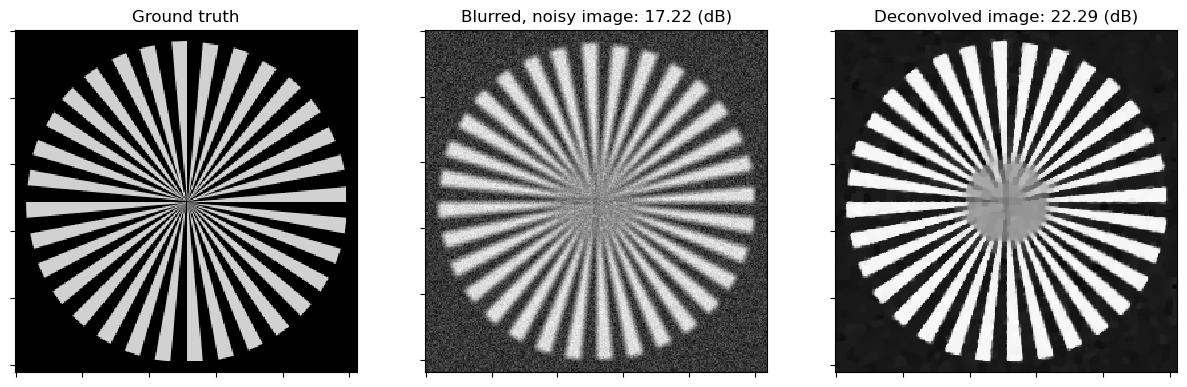

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
nc = n // 2
yc = y[nc:-nc, nc:-nc]
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, yc), fig=fig, ax=ax[1])
plot.imview(
    solver.x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, solver.x), fig=fig, ax=ax[2]
)
fig.show()

Plot convergence statistics.

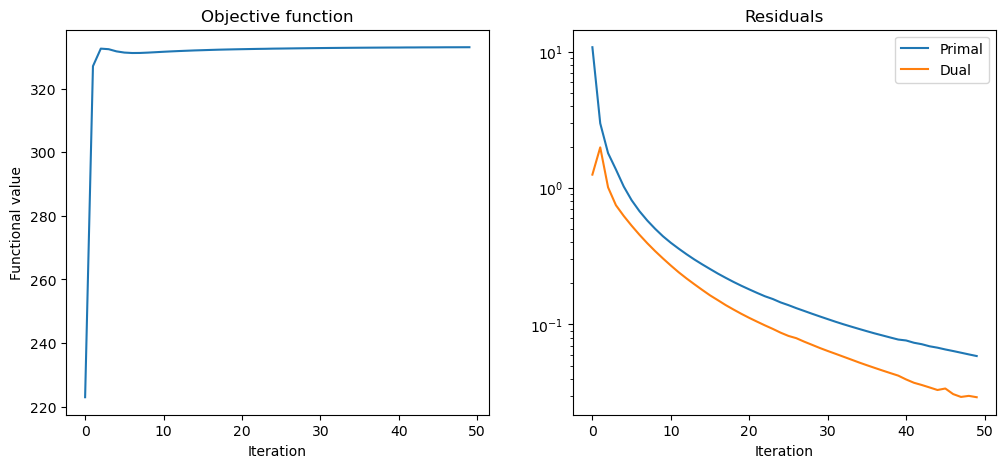

In [8]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()